In [ ]:
# !pip install -q huggingface_hub pandas pyarrow

from huggingface_hub import list_repo_files, hf_hub_download
import pandas as pd, numpy as np, re
import os
import matplotlib.pyplot as plt
import seaborn as sns


**OneStopEnglish**

Average word counts increase with text level, from ~534 words at elementary to ~678 at intermediate and ~825 at advanced. This confirms that text complexity in the dataset scales as expected, with advanced articles consistently longer and more detailed than lower-level ones.



In [ ]:
import requests
from io import StringIO

def get_csv_filenames_from_github():
    """Get list of all CSV files from GitHub"""
    api_url = "https://api.github.com/repos/nishkalavallabhi/OneStopEnglishCorpus/contents/Texts-Together-OneCSVperFile"

    response = requests.get(api_url)

    if response.status_code == 200:
        files = response.json()
        csv_files = [f['name'] for f in files if f['name'].endswith('.csv')]
        return csv_files
    else:
        raise Exception(f"Failed to get file list: {response.status_code}")

"""Load all OneStopEnglish CSVs from GitHub"""
base_url = "https://raw.githubusercontent.com/nishkalavallabhi/OneStopEnglishCorpus/master/Texts-Together-OneCSVperFile"

# Get list of CSV files
csv_files = get_csv_filenames_from_github()
print(f"Found {len(csv_files)} CSV files")

all_data = []

for csv_file in csv_files:
    article_id = csv_file.replace('.csv', '')
    url = f"{base_url}/{csv_file}"

    try:
        response = requests.get(url)
        if response.status_code == 200:
            df_article = pd.read_csv(StringIO(response.text))
            df_article['article_id'] = article_id
            all_data.append(df_article)
        else:
            print(f"Failed {article_id}: {response.status_code}")
    except Exception as e:
        print(f"Error {article_id}: {e}")

# Combine all articles
original_df = pd.concat(all_data, ignore_index=True)


Found 189 CSV files


In [ ]:
df = original_df.copy()
df.head()

,Elementary,Intermediate,Advanced,article_id,Intermediate,Unnamed: 3
0,"When you see the word Amazon, what’s\nthe firs...","When you see the word Amazon, what’s\nthe firs...","When you see the word Amazon, what’s the\nfirs...",Amazon,NaN,NaN
1,These are the questions in a debate about\nthe...,These are questions in a debate about how\nto ...,These questions have risen to the fore in an\n...,Amazon,NaN,NaN
2,Amazon has asked for its company\nname to be a...,The Seattle-based company has applied\nfor its...,The Seattle-based company has applied for its\...,Amazon,NaN,NaN
3,There are many other disputed claims to\nnames...,Together with many other disputed claims\nto n...,Along with dozens of other disputed claims to\...,Amazon,NaN,NaN
4,"Until now, the differences between\ncommercial...","Until now, the differences between\ncommercial...","Until now, the differences between commercial,...",Amazon,NaN,NaN


In [ ]:
# Some texts have a type in the intermediate column name so checking to see the difference
print(original_df['Intermediate'].count())
print(original_df['Intermediate'].isna().sum())

print(original_df['Intermediate '].count())
print(original_df['Intermediate '].isna().sum())

147
2516
2259
404


In [ ]:
# Merge the two intermediate columns for a single column
df['Intermediate'] = df['Intermediate'].fillna(df['Intermediate '])
print(df['Intermediate'].count())
print(df['Intermediate'].isna().sum())

print(df['Intermediate '].count())
print(df['Intermediate '].isna().sum())

2406
257
2259
404


In [ ]:
# After loading with load_all_onestop_csvs()

# Drop the unnamed columns (they appear to be empty/duplicate)
df = df.drop(columns=[col for col in df.columns if 'Unnamed' in col])
df = df.drop(columns=['Intermediate '])

df.head(5)

,Elementary,Intermediate,Advanced,article_id
0,"When you see the word Amazon, what’s\nthe firs...","When you see the word Amazon, what’s\nthe firs...","When you see the word Amazon, what’s the\nfirs...",Amazon
1,These are the questions in a debate about\nthe...,These are questions in a debate about how\nto ...,These questions have risen to the fore in an\n...,Amazon
2,Amazon has asked for its company\nname to be a...,The Seattle-based company has applied\nfor its...,The Seattle-based company has applied for its\...,Amazon
3,There are many other disputed claims to\nnames...,Together with many other disputed claims\nto n...,Along with dozens of other disputed claims to\...,Amazon
4,"Until now, the differences between\ncommercial...","Until now, the differences between\ncommercial...","Until now, the differences between commercial,...",Amazon


# Cleaning:





In [ ]:
# Define columns & issue scan function:


# Define which columns to check
TEXT_COLS = [c for c in ["Elementary", "Intermediate", "Advanced"] if c in df.columns]

def scan_issues(frame, cols=TEXT_COLS):
    report = {}
    for col in cols:
        s = frame[col].astype(str).fillna("")
        report[col] = {
            "rows": len(s),
            "missing_end_punct": int((~s.str.contains(r"[.?!]['\"”’)\]]*\s*$", regex=True)).sum()),
            "multi_spaces": int(s.str.contains(r"\s{2,}", regex=True).sum()),
            "strange_chars": int(s.str.contains(r"[^\x09\x0A\x0D\x20-\x7E]", regex=True).sum()),
            "suspicious_short_tokens": int(s.str.contains(r"\b[b-df-hj-np-tv-z]{2,}\b", flags=re.I, regex=True).sum()),
            "nbsp_or_unicode_space": int(s.str.contains(r"[\u00A0\u2000-\u200B]", regex=True).sum()),
            "double_punct": int(s.str.contains(r"[.!?]{2,}|,{2,}|;;+|::+", regex=True).sum()),
            "unbalanced_quotes": int((s.str.count(r'"') % 2 != 0).sum()),
            "unbalanced_parens": int((s.str.count(r"\(") != s.str.count(r"\)")).sum()),
        }
    return pd.DataFrame(report).T

# Run initial scan before cleaning
issue_report_before = scan_issues(df)
display(issue_report_before)


,rows,missing_end_punct,multi_spaces,strange_chars,suspicious_short_tokens,nbsp_or_unicode_space,double_punct,unbalanced_quotes,unbalanced_parens
Elementary,2663,556,168,1461,618,0,14,3,0
Intermediate,2663,283,216,1760,892,0,18,3,0
Advanced,2663,29,265,2028,1091,0,20,7,0


In [ ]:
import re, unicodedata
from collections import Counter

def find_strange_characters(df: pd.DataFrame, text_cols):
    # keep only columns that actually exist
    cols = [c for c in text_cols if c in df.columns]
    if not cols:
        raise ValueError("None of the specified text columns exist in the DataFrame.")

    # 1) Concatenate all text into a single string
    all_text_series = pd.concat([df[c].astype(str).fillna("") for c in cols], ignore_index=True)
    all_text = all_text_series.str.cat(sep=" ")

    # 2) Find characters outside ASCII printable range (space 0x20 to tilde 0x7E)
    strange_chars = re.findall(r"[^\x20-\x7E]", all_text)

    # 3) Count and annotate
    counter = Counter(strange_chars)
    rows = [(ch, f"U+{ord(ch):04X}", unicodedata.name(ch, "UNKNOWN"), cnt)
            for ch, cnt in counter.most_common()]

    out = pd.DataFrame(rows, columns=["char", "hex", "name", "count"])
    return out


In [ ]:
TEXT_COLS = ["Elementary", "Intermediate", "Advanced"]
strange_report = find_strange_characters(df, TEXT_COLS)
display(strange_report.head(25))  # top offenders



,char,hex,name,count
0,\n,U+000A,UNKNOWN,23730
1,’,U+2019,RIGHT SINGLE QUOTATION MARK,5844
2,“,U+201C,LEFT DOUBLE QUOTATION MARK,4816
3,”,U+201D,RIGHT DOUBLE QUOTATION MARK,4632
4,–,U+2013,EN DASH,1816
5,\r,U+000D,UNKNOWN,1327
6,£,U+00A3,POUND SIGN,466
7,‘,U+2018,LEFT SINGLE QUOTATION MARK,280
8,€,U+20AC,EURO SIGN,114
9,,U+0019,UNKNOWN,81


We focused on strange characters because biomedical text often includes non-standard symbols like Greek letters and units, which must be cleaned or standardized for accurate model processing.


In [ ]:
!pip -q install ftfy

In [ ]:
# Clean & Normalize Utilities:
import ftfy

COMMON_TYPO_MAP = {
    r"\bnd\b": "and",
    r"\bbt\b": "but",
    r"\btht\b": "that",
    r"\bwht\b": "what",
    r"\bteh\b": "the",
    r"\bfrm\b": "from",
    r"\bcuz\b": "because",
    r"\bcld\b": "could",
    r"\bshd\b": "should",
    r"\bwud\b": "would",
    r"\bcdnt\b": "couldn’t",
}


STRANGE_CHAR_NORMALIZE.update({
    "\n": " ",
    "\r": " ",
    "\u0001": "",
    "\u0003": "",
    "\u0013": "",
    "\u0019": "",
    "\u001C": "",
    "\u001D": "",
    "‘": "'",
    "’": "'",
    "“": '"',
    "”": '"',
    "–": "-",
    "…": "...",
    "£": "GBP",
    "€": "EUR",
    "°": " degrees ",
})


PROTECT_PATTERNS = [
    r"\b[A-Z]{2,}\b",              # All-caps acronyms (DNA, WHO, BBC)
    r"\b[A-Za-z]+\d+[A-Za-z]*\b",  # Gene/protein codes (H1N1, p53)
    r"\b[a-z]{1,3}\.[A-Z]\b",      # Initials like "Dr.", "Mr.", "Ms."
    r"\bNaCl\b|\bH2O\b|\bMg\b",    # Chemical formulas
]

def apply_common_typos(text: str) -> str:
    for pat, repl in COMMON_TYPO_MAP.items():
        text = re.sub(pat, repl, text, flags=re.IGNORECASE)
    return text

def protect_tokens(text: str):
    mask_map, i = {}, 0
    def _mask(m):
        nonlocal i
        tok = m.group(0)
        key = f"§§PROT{i}§§"
        mask_map[key] = tok
        i += 1
        return key
    for pat in PROTECT_PATTERNS:
        text = re.sub(pat, _mask, text)
    return text, mask_map

def unprotect_tokens(text: str, mask_map: dict) -> str:
    for key, val in mask_map.items():
        text = text.replace(key, val)
    return text

def normalize_strange_chars(s: str) -> str:
    return "".join(STRANGE_CHAR_NORMALIZE.get(ch, ch) for ch in s)

# --- smarter terminal punctuation handler ---
def add_terminal_punct(s: str) -> str:
    t = s.strip()
    if len(t.split()) <= 4 or re.match(r'^\s*[-•*]\s', t):
        return t
    if re.search(r'[A-Za-z0-9][\)\]"]$', t) and not re.search(r'[.?!][\)\]"]$', t):
        t = re.sub(r'([A-Za-z0-9])([\)\]"])$', r'\1.\2', t)
        return t
    if not t.endswith(('.', '!', '?')) and re.search(r'[A-Za-z0-9)]$', t):
        t += '.'
    return t

def normalize_text(s: str) -> str:
    if not isinstance(s, str):
        s = "" if pd.isna(s) else str(s)
    s = ftfy.fix_text(s)
    s, mask_map = protect_tokens(s)
    s = normalize_strange_chars(s)
    s = re.sub(r"\.{2,}", "...", s)
    s = re.sub(r"([!?]){2,}", r"\1", s)
    s = re.sub(r"(,){2,}", ",", s)
    s = re.sub(r"\s+", " ", s).strip()
    s = apply_common_typos(s)
    s = re.sub(r"\s+([,;:])", r"\1", s)
    s = re.sub(r"([,;:])(?!\s|$)", r"\1 ", s)
    s = re.sub(r"\s*([.?!])", r"\1", s)
    if s.count('"') % 2 == 1:
        s += '"'
    s = add_terminal_punct(s)
    s = unprotect_tokens(s, mask_map)
    return s


In [ ]:
# Apply cleaning
TEXT_COLS = [c for c in ["Elementary", "Intermediate", "Advanced"] if c in df.columns]
df_before = df.copy(deep=True)

for col in TEXT_COLS:
    df[col] = df[col].astype(str).apply(normalize_text)

print("Cleaning applied to:", TEXT_COLS)


Cleaning applied to: ['Elementary', 'Intermediate', 'Advanced']


In [ ]:
# Re-scan and show summary only
issue_report_after = scan_issues(df)

# Merge just to compute differences
comparison = issue_report_before.join(
    issue_report_after, lsuffix="_before", rsuffix="_after", how="outer"
).fillna(0)

metrics = ["missing_end_punct", "strange_chars", "multi_spaces", "suspicious_short_tokens"]
for m in metrics:
    if f"{m}_before" in comparison and f"{m}_after" in comparison:
        comparison[f"Δ_{m}"] = comparison[f"{m}_before"] - comparison[f"{m}_after"]
        denom = comparison[f"{m}_before"].replace(0, pd.NA)
        comparison[f"%_drop_{m}"] = (100 * comparison[f"Δ_{m}"] / denom)

# Display only cleaned (after) counts
print("\n--- Cleaned Dataset Issue Counts (After Cleaning) ---")
display(issue_report_after.round(1))

# Print summary of improvements
print("\n--- Summary of Improvements ---")
for m in metrics:
    if f"Δ_{m}" in comparison.columns:
        total_drop = int(comparison[f"Δ_{m}"].sum())
        avg_drop = comparison[f"%_drop_{m}"].mean(skipna=True)
        print(f"{m:<25} drop = {total_drop:>6}  |  avg % improvement = {avg_drop:>6.1f}%")



--- Cleaned Dataset Issue Counts (After Cleaning) ---


,rows,missing_end_punct,multi_spaces,strange_chars,suspicious_short_tokens,nbsp_or_unicode_space,double_punct,unbalanced_quotes,unbalanced_parens
Elementary,2663,539,0,454,542,0,20,0,0
Intermediate,2663,260,0,549,813,0,32,0,0
Advanced,2663,8,0,645,996,0,38,0,0



--- Summary of Improvements ---
missing_end_punct         drop =     61  |  avg % improvement =   27.9%
strange_chars             drop =   3601  |  avg % improvement =   68.6%
multi_spaces              drop =    649  |  avg % improvement =  100.0%
suspicious_short_tokens   drop =    250  |  avg % improvement =   10.0%


Verify structure and completeness:
Checking that each article has all three readability levels (elementary, intermediate, advanced) and no missing or duplicate entries to ensure balanced triplets for training.

In [ ]:
df.isna().sum()

,0
Elementary,0
Intermediate,0
Advanced,0
article_id,0


In [ ]:
# drop texts without all three levels present (COMMENT THIS OUT IF ALL THREE LEVELS ARE NOT NEEDED)
df.dropna(inplace=True)
df.isna().sum()

,0
Elementary,0
Intermediate,0
Advanced,0
article_id,0


In [ ]:
wide = df.groupby('article_id').agg({
    'Elementary': lambda x: '\n'.join(x.dropna().astype(str)),
    'Intermediate': lambda x: '\n'.join(x.dropna().astype(str)),
    'Advanced': lambda x: '\n'.join(x.dropna().astype(str))
}).reset_index()

wide = wide.rename(columns={
    'Elementary': 'elem',
    'Intermediate': 'inter',
    'Advanced': 'adv'
})

In [ ]:
wide.head(5)

,article_id,elem,inter,adv
0,Amazon,"When you see the word Amazon, what's the first...","When you see the word Amazon, what's the first...","When you see the word Amazon, what's the first..."
1,Amsterdam,"To tourists, Amsterdam still seems very libera...","To tourists, Amsterdam still seems very libera...","Amsterdam still looks liberal to tourists, who..."
2,Anita,"Anitta, a music star from Brazil, has millions...","Brazil's latest funk sensation, Anitta, has wo...","Brazil's latest funk sensation, Anitta, has wo..."
3,Arctic mapping,Google has made maps of the world's highest mo...,"It has mapped the world's highest peaks, the o...","It has charted the world's highest peaks, the ..."
4,Banksy,The auction of a Banksy painting that disappea...,The controversial auction of a Banksy mural th...,The controversial auction of a Banksy mural th...


In [ ]:
!pip install textstat

=== FLESCH-KINCAID GRADE LEVEL (lower = easier) ===
Elementary:   Mean=8.30, Median=8.12
Intermediate: Mean=10.01, Median=9.81
Advanced:     Mean=11.29, Median=11.14

=== FLESCH READING EASE (higher = easier) ===
Elementary:   Mean=65.08, Median=65.73
Intermediate: Mean=57.75, Median=58.53
Advanced:     Mean=52.93, Median=54.06


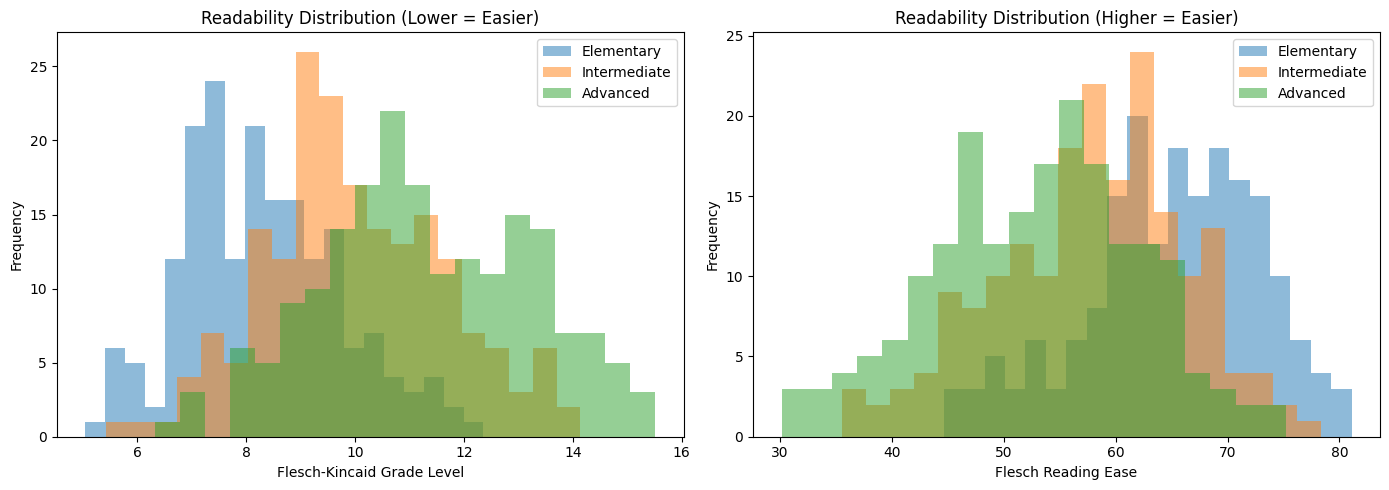

In [ ]:
# Checking that the three levels are significantly different reading levels

import textstat
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Calculate readability scores for each level
wide['elem_fkgl'] = wide['elem'].apply(lambda x: textstat.flesch_kincaid_grade(str(x)))
wide['inter_fkgl'] = wide['inter'].apply(lambda x: textstat.flesch_kincaid_grade(str(x)))
wide['adv_fkgl'] = wide['adv'].apply(lambda x: textstat.flesch_kincaid_grade(str(x)))

wide['elem_fre'] = wide['elem'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
wide['inter_fre'] = wide['inter'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
wide['adv_fre'] = wide['adv'].apply(lambda x: textstat.flesch_reading_ease(str(x)))

# Step 2: Summary statistics
print("=== FLESCH-KINCAID GRADE LEVEL (lower = easier) ===")
print(f"Elementary:   Mean={wide['elem_fkgl'].mean():.2f}, Median={wide['elem_fkgl'].median():.2f}")
print(f"Intermediate: Mean={wide['inter_fkgl'].mean():.2f}, Median={wide['inter_fkgl'].median():.2f}")
print(f"Advanced:     Mean={wide['adv_fkgl'].mean():.2f}, Median={wide['adv_fkgl'].median():.2f}")

print("\n=== FLESCH READING EASE (higher = easier) ===")
print(f"Elementary:   Mean={wide['elem_fre'].mean():.2f}, Median={wide['elem_fre'].median():.2f}")
print(f"Intermediate: Mean={wide['inter_fre'].mean():.2f}, Median={wide['inter_fre'].median():.2f}")
print(f"Advanced:     Mean={wide['adv_fre'].mean():.2f}, Median={wide['adv_fre'].median():.2f}")

# Step 3: Visualize the differences
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Flesch-Kincaid Grade Level
axes[0].hist(wide['elem_fkgl'], alpha=0.5, label='Elementary', bins=20)
axes[0].hist(wide['inter_fkgl'], alpha=0.5, label='Intermediate', bins=20)
axes[0].hist(wide['adv_fkgl'], alpha=0.5, label='Advanced', bins=20)
axes[0].set_xlabel('Flesch-Kincaid Grade Level')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Readability Distribution (Lower = Easier)')
axes[0].legend()

# Plot 2: Flesch Reading Ease
axes[1].hist(wide['elem_fre'], alpha=0.5, label='Elementary', bins=20)
axes[1].hist(wide['inter_fre'], alpha=0.5, label='Intermediate', bins=20)
axes[1].hist(wide['adv_fre'], alpha=0.5, label='Advanced', bins=20)
axes[1].set_xlabel('Flesch Reading Ease')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Readability Distribution (Higher = Easier)')
axes[1].legend()

plt.tight_layout()
plt.show()

Clean text (remove headers, normalize):
Removing “Intermediate\n…”, stray whitespace; keeps readability stats consistent.

In [ ]:
def clean_text(t:str)->str:
    t = re.sub(r"^\s*(Elementary|Intermediate|Advanced)\s*\n?", "", t, flags=re.I)
    t = re.sub(r"\s+", " ", t).strip()
    return t

df["Elementary"] = df["Elementary"].astype(str).apply(clean_text)
df["Intermediate"] = df["Intermediate"].astype(str).apply(clean_text)
df["Advanced"] = df["Advanced"].astype(str).apply(clean_text)


Pivot to wide & build pairs: Aligning the three versions of each article and create explicit (source → target) pairs.

In [ ]:
df.head(5)

,Elementary,Intermediate,Advanced,article_id
0,"When you see the word Amazon, what's the first...","When you see the word Amazon, what's the first...","When you see the word Amazon, what's the first...",Amazon
1,These are the questions in a debate about the ...,These are questions in a debate about how to r...,These questions have risen to the fore in an a...,Amazon
2,Amazon has asked for its company name to be a ...,The Seattle-based company has applied for its ...,The Seattle-based company has applied for its ...,Amazon
3,"There are many other disputed claims to names,...",Together with many other disputed claims to na...,Along with dozens of other disputed claims to ...,Amazon
4,"Until now, the differences between commercial,...","Until now, the differences between commercial,...","Until now, the differences between commercial,...",Amazon


# Preprocessing:
### OneStopEnglish:

In [ ]:
# Build paired examples for multi-level training
pairs = pd.concat([
    wide[["adv","inter"]].rename(columns={"adv":"source","inter":"target"}).assign(direction="adv→inter"),
    wide[["adv","elem"]].rename(columns={"adv":"source","elem":"target"}).assign(direction="adv→elem"),
    wide[["inter","elem"]].rename(columns={"inter":"source","elem":"target"}).assign(direction="inter→elem"),
], ignore_index=True)

# sanity
assert pairs["source"].notna().all() and pairs["target"].notna().all()
pairs.sample(3)

# AFTER building `pairs`
pairs["ctl"] = pairs["direction"].map({
    "adv→inter": "<TO_INTER>",
    "adv→elem":  "<TO_ELEM>",
    "inter→elem":"<TO_ELEM>",
})
pairs["source_ctl"] = pairs["ctl"] + " " + pairs["source"]
# ↓ Use `source_ctl` as the encoder input going forward
pairs = pairs[["source_ctl","target","direction"]].rename(columns={"source_ctl":"source"})



In [ ]:
import difflib

# Check similarity on your OneStopEnglish pairs
print("=== OneStopEnglish Data Quality Check ===\n")

# Sample 50 pairs
sample = pairs.sample(min(50, len(pairs)), random_state=42)

similarities = []
examples_by_level = {'low': [], 'medium': [], 'high': []}

for idx, row in sample.iterrows():
    source = row['source'].replace('<TO_ELEM> ', '').replace('<TO_INTER> ', '')
    target = row['target']

    sim = difflib.SequenceMatcher(None, source, target).ratio()
    similarities.append(sim)

    # Collect examples
    if sim > 0.80 and len(examples_by_level['high']) < 2:
        examples_by_level['high'].append({'sim': sim, 'dir': row['direction'], 'src': source[:100], 'tgt': target[:100]})
    elif 0.65 <= sim <= 0.80 and len(examples_by_level['medium']) < 2:
        examples_by_level['medium'].append({'sim': sim, 'dir': row['direction'], 'src': source[:100], 'tgt': target[:100]})
    elif sim < 0.65 and len(examples_by_level['low']) < 2:
        examples_by_level['low'].append({'sim': sim, 'dir': row['direction'], 'src': source[:100], 'tgt': target[:100]})

avg_sim = sum(similarities) / len(similarities)

print(f"Average Similarity: {avg_sim:.1%}")
print(f"\nDistribution:")
print(f"  Very similar (>80%): {sum(1 for s in similarities if s > 0.80)}/{len(similarities)}")
print(f"  Similar (65-80%):    {sum(1 for s in similarities if 0.65 <= s <= 0.80)}/{len(similarities)}")
print(f"  Different (<65%):    {sum(1 for s in similarities if s < 0.65)}/{len(similarities)}")

print(f"\n=== Example: High Similarity (>80%) ===")
for ex in examples_by_level['high']:
    print(f"\n{ex['dir']} - {ex['sim']:.1%} similar")
    print(f"Source: {ex['src']}...")
    print(f"Target: {ex['tgt']}...")

if avg_sim > 0.75:
    print(f"\n Problem confirmed: avg={avg_sim:.1%}")
    print("Next step: Filter pairs with similarity <70% and retrain")
elif avg_sim > 0.65:
    print(f"\n Moderate similarity: avg={avg_sim:.1%}")
    print("Try filtering pairs with similarity <65%")
else:
    print(f"\n Looks OK: avg={avg_sim:.1%}")
    print("The problem might be elsewhere")

=== OneStopEnglish Data Quality Check ===

Average Similarity: 41.8%

Distribution:
  Very similar (>80%): 1/50
  Similar (65-80%):    8/50
  Different (<65%):    41/50

=== Example: High Similarity (>80%) ===

adv→inter - 82.0% similar
Source: The tranquil chorus of the natural world is in danger of being lost to today's generation as people ...
Target: The tranquil sounds of the natural world might be lost to today's generation as people screen out th...

 Looks OK: avg=41.8%
The problem might be elsewhere


In [ ]:
# After creating wide, add this verification:
print("\n=== CHECKING ALIGNMENT ===")
for i in range(3):
    print(f"\n--- Triplet {i} ---")
    print(f"ELEM start: {wide.iloc[i]['elem'][:80]}...")
    print(f"INTER start: {wide.iloc[i]['inter'][:80]}...")
    print(f"ADV start: {wide.iloc[i]['adv'][:80]}...")


=== CHECKING ALIGNMENT ===

--- Triplet 0 ---
ELEM start: When you see the word Amazon, what's the first thing you think of - the world's ...
INTER start: When you see the word Amazon, what's the first thing you think of - the world's ...
ADV start: When you see the word Amazon, what's the first thing that springs to mind - the ...

--- Triplet 1 ---
ELEM start: To tourists, Amsterdam still seems very liberal. Recently the city's Mayor told ...
INTER start: To tourists, Amsterdam still seems very liberal. Recently the city's Mayor assur...
ADV start: Amsterdam still looks liberal to tourists, who were recently assured by the Labo...

--- Triplet 2 ---
ELEM start: Anitta, a music star from Brazil, has millions of fans, but she is at the centre...
INTER start: Brazil's latest funk sensation, Anitta, has won millions of fans by making the f...
ADV start: Brazil's latest funk sensation, Anitta, has won millions of fans by taking the f...


4. (Train/Validation split): dividing the pairs dataframe for model training and evaluation:

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    pairs,
    test_size=0.15,
    random_state=42,
    stratify=pairs["direction"]
)

print("Train:", len(train_df), "Validation:", len(val_df))
print(train_df["direction"].value_counts())


Train: 481 Validation: 86
direction
adv→elem      161
adv→inter     160
inter→elem    160
Name: count, dtype: int64


In [ ]:
train_df.head(5)

,source,target,direction
173,<TO_INTER> Setting aside epic disaster-movie m...,"Apart from volcanoes, hurricanes and earthquak...",adv→inter
376,<TO_ELEM> More than one million British worker...,More than one million British workers might be...,adv→elem
424,<TO_ELEM> Barack Obama flew back to Washington...,Barack Obama flew back to Washington and his d...,inter→elem
408,<TO_ELEM> The Duke and Duchess of Cambridge wo...,The Duke and Duchess of Cambridge have won the...,inter→elem
377,<TO_ELEM> Low-income countries will remain on ...,Poorer countries will be most affected by clim...,adv→elem


5. Tokenizer + length coverage check: making sure truncation won’t wreck inputs

In [ ]:
# Install and import tokenizer
!pip -q install transformers accelerate
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained("facebook/bart-base")

# Count tokens per text (no truncation)
def token_len(texts):
    return texts.apply(lambda s: len(tok(s, truncation=False)["input_ids"]))

# Compute token lengths for source and target pairs
src_len = token_len(train_df["source"])
tgt_len = token_len(train_df["target"])

# Check what fraction fits within model limits (BART max 1024 tokens)
print("Src ≤512:", (src_len<=512).mean(), "Src ≤1024:", (src_len<=1024).mean())
print("Tgt ≤128:", (tgt_len<=128).mean(), "Tgt ≤256:", (tgt_len<=256).mean())

# Show summary stats for token lengths
src_len.describe(), tgt_len.describe()


Src ≤512: 0.006237006237006237 Src ≤1024: 0.5322245322245323
Tgt ≤128: 0.0 Tgt ≤256: 0.0


(count     481.000000
 mean     1017.523909
 std       208.195111
 min       422.000000
 25%       871.000000
 50%      1006.000000
 75%      1169.000000
 max      1849.000000
 Name: source, dtype: float64,
 count     481.000000
 mean      759.212058
 std       158.903839
 min       353.000000
 25%       636.000000
 50%       762.000000
 75%       853.000000
 max      1464.000000
 Name: target, dtype: float64)

In [ ]:
max_source_length = 1024
max_target_length = 1024 # Increments of 64, > 896

In [ ]:
from transformers import AutoTokenizer, Seq2SeqTrainingArguments, AutoModelForSeq2SeqLM, Seq2SeqTrainer, DataCollatorForSeq2Seq

In [ ]:
def tokenize(examples):
    # Tokenize source (encoder input)
    inputs = tok(
        examples["source"],
        max_length=max_source_length,
        truncation=True,
        padding="max_length",
    )

    # Tokenize target (decoder output)
    targets = tok(
        examples["target"],
        max_length=max_target_length,
        truncation=True,
        padding="max_length"
    )

    inputs["labels"] = targets["input_ids"]
    return inputs

# Training:


In [ ]:
# !pip install datasets

In [ ]:
from datasets import Dataset
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
train_dataset = Dataset.from_pandas(train_df).map(tokenize, batched=True, remove_columns=list(train_df.columns))
val_dataset = Dataset.from_pandas(val_df).map(tokenize, batched=True, remove_columns=list(val_df.columns))

Map:   0%|          | 0/481 [00:00<?, ? examples/s]

Map:   0%|          | 0/86 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-base")

In [ ]:
args = Seq2SeqTrainingArguments(
    output_dir="./results",
    predict_with_generate=True,
    generation_max_length=512,
    learning_rate=3e-5,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=16,
    num_train_epochs=10,
    seed=42,
    report_to="tensorboard",
    fp16=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="rougeL"
)

In [ ]:
# Add padding for tensor uniformity
collator = DataCollatorForSeq2Seq(
    tokenizer=tok,
    model=model,
    padding=True,
    label_pad_token_id=-100  # Ignore padding in loss
)

In [ ]:
!pip install evaluate

In [ ]:
!pip install rouge_score

In [ ]:
import evaluate
import numpy as np

# Load ROUGE metric
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    decoded_preds = tok.batch_decode(predictions, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tok.pad_token_id)
    decoded_labels = tok.batch_decode(labels, skip_special_tokens=True)

    rouge_result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )

    pred_lens = [len(pred.split()) for pred in decoded_preds]
    label_lens = [len(label.split()) for label in decoded_labels]

    return {
        "rouge1": round(rouge_result["rouge1"], 4),
        "rouge2": round(rouge_result["rouge2"], 4),
        "rougeL": round(rouge_result["rougeL"], 4),
        "gen_len": round(np.mean(pred_lens), 1),
        "compression_ratio": round(np.mean(pred_lens) / np.mean(label_lens), 3),
    }

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tok,
    compute_metrics=compute_metrics,
    data_collator=collator
)

/tmp/ipython-input-3058425609.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

trainer.train()

print("\n Training complete!")

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Gen Len,Compression Ratio
1,No log,2.989682,0.654700,0.461300,0.506300,393.800000,0.687000
2,No log,2.245676,0.657600,0.468700,0.518900,398.400000,0.695000
3,No log,1.895457,0.661400,0.475500,0.528000,400.500000,0.699000
4,No log,1.642415,0.660900,0.473900,0.529400,402.300000,0.702000
5,No log,1.457150,0.659800,0.471900,0.525900,402.400000,0.702000
6,No log,1.320247,0.658800,0.471100,0.524000,402.100000,0.702000
7,No log,1.215384,0.659700,0.472000,0.526200,402.200000,0.702000
8,No log,1.149359,0.659700,0.471900,0.529800,402.300000,0.702000
9,No log,1.112223,0.659600,0.471500,0.526700,399.900000,0.698000
10,No log,1.099108,0.661200,0.473300,0.532800,401.900000,0.701000


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].



 Training complete!


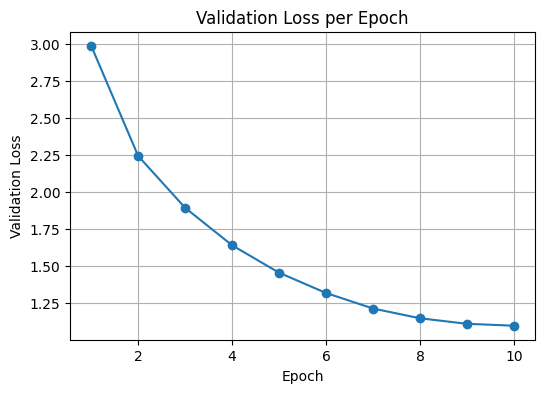

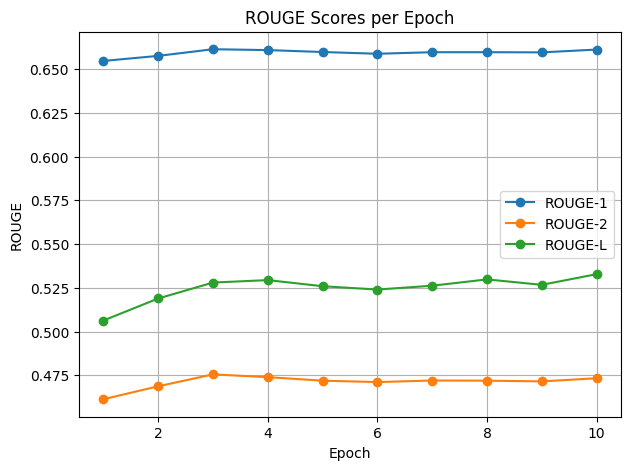

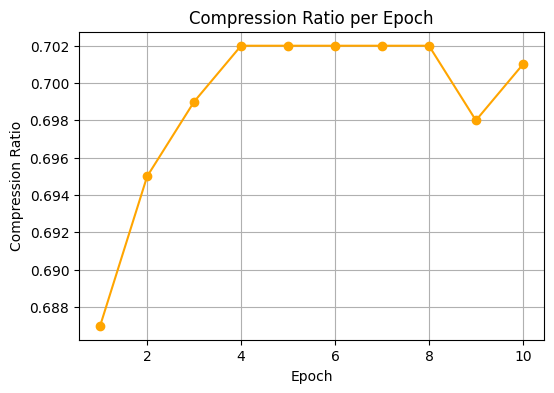

In [ ]:
import matplotlib.pyplot as plt


log_history = trainer.state.log_history

# Parse evaluation metrics
eval_metrics = [x for x in log_history if 'eval_loss' in x]

data = {
    "epoch": [x['epoch'] for x in eval_metrics],
    "val_loss": [x['eval_loss'] for x in eval_metrics],
    "rouge1": [x.get('eval_rouge1', 0) for x in eval_metrics],
    "rouge2": [x.get('eval_rouge2', 0) for x in eval_metrics],
    "rougeL": [x.get('eval_rougeL', 0) for x in eval_metrics],
    "compression": [x.get('eval_compression_ratio', 0) for x in eval_metrics]
}

df = pd.DataFrame(data)

# 1. Validation loss vs. epochs
plt.figure(figsize=(6,4))
plt.plot(df["epoch"], df["val_loss"], marker="o")
plt.title("Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.grid(True)
plt.show()

# 2. ROUGE scores
plt.figure(figsize=(7,5))
plt.plot(df["epoch"], df["rouge1"], label="ROUGE-1", marker="o")
plt.plot(df["epoch"], df["rouge2"], label="ROUGE-2", marker="o")
plt.plot(df["epoch"], df["rougeL"], label="ROUGE-L", marker="o")
plt.title("ROUGE Scores per Epoch")
plt.xlabel("Epoch")
plt.ylabel("ROUGE")
plt.legend()
plt.grid(True)
plt.show()

# 3. Compression ratio
plt.figure(figsize=(6,4))
plt.plot(df["epoch"], df["compression"], marker="o", color="orange")
plt.title("Compression Ratio per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Compression Ratio")
plt.grid(True)
plt.show()


In [ ]:
def generate_no_copy(model, tokenizer, source_text, device='cuda'):
    """Generate without copying source phrases"""

    inputs = tokenizer(source_text, return_tensors="pt", max_length=1024, truncation=True)
    input_ids = inputs.input_ids.to(device)

    # Extract source 5-grams
    source_tokens = input_ids[0].tolist()
    source_5grams = set()
    for i in range(len(source_tokens) - 4):
        source_5grams.add(tuple(source_tokens[i:i+5]))

    # Simple ban function
    def ban_source_ngrams(input_ids, scores):
        for batch_idx in range(input_ids.shape[0]):
            if input_ids.shape[1] >= 4:
                prefix = tuple(input_ids[batch_idx, -4:].tolist())
                for ngram in source_5grams:
                    if ngram[:4] == prefix:
                        scores[batch_idx, ngram[4]] = float('-inf')
        return scores

    from transformers import LogitsProcessorList

    outputs = model.generate(
        input_ids,
        attention_mask=inputs.attention_mask.to(device),
        max_length=512,
        min_length=50,
        num_beams=6,
        no_repeat_ngram_size=3,
        repetition_penalty=1.3,
        logits_processor=LogitsProcessorList([ban_source_ngrams]),  # Block copying
        early_stopping=True
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [ ]:
!pip install torch

In [ ]:
def test_samples(model, val_df, num_samples=5):
    """Test if generation is coherent and simplified"""

    for i in range(min(num_samples, len(val_df))):
        row = val_df.iloc[i]
        generated = generate_no_copy(model, tok, row['source'], device)

        print(f"\n{'='*80}")
        print(f"Example {i+1} | Direction: {row['direction']}")
        print(f"{'='*80}")
        print(f"\nSOURCE (first 300 chars):")
        print(row["source"].replace("\n", " ") + "...")
        print(f"\nTARGET (first 300 chars):")
        print(row["target"].replace("\n", " ") + "...")
        print(f"\nGENERATED (first 300 chars):")
        print(generated.replace("\n", " ") + "...")

        # Quality metrics
        print(f"\nWord counts: Source={len(row['source'].split())}, "
              f"Target={len(row['target'].split())}, "
              f"Generated={len(generated.split())}")

        # Check for repetition (bad sign)
        words = generated.split()
        unique_ratio = len(set(words)) / len(words) if words else 0
        print(f"Unique word ratio: {unique_ratio:.2f} (>0.7 is good)")

        if unique_ratio < 0.5:
            print("WARNING: High repetition detected!")
        elif unique_ratio > 0.7:
            print("✓ Good lexical diversity")

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()
test_samples(model, val_df, num_samples=5)


Example 1 | Direction: inter→elem

SOURCE (first 300 chars):
<TO_ELEM> Noise from ships may disturb animals such as killer whales and dolphins much more than people previously thought. New research shows that underwater noise could disturb the animals' communication and ability to and prey. The low rumble of passing ships has, for a long time, been connected to the disturbance of large whales. But, §§PROT0§§ researchers have also found noise at medium and higher frequencies, including at 20, 000Hz where killer whales, also known as orcas, hear best. These noises could be disturbing the ability of killer whales to communicate and use echo to and their prey. Dolphins and porpoises, which also hear at higher frequencies, may have the same problems. The ndings suggest that the noise could affect the endangered population of killer whales that are found near the shipping lanes up the west coast of the §§PROT0§§. "The main concern of this is that even a slight increase in sound may make ech

In [ ]:
log_history = trainer.state.log_history

# Extract metrics
eval_losses = [x['eval_loss'] for x in log_history if 'eval_loss' in x]
rouge1_scores = [x['eval_rouge1'] for x in log_history if 'eval_rouge1' in x]
rouge2_scores = [x['eval_rouge2'] for x in log_history if 'eval_rouge2' in x]
rougeL_scores = [x['eval_rougeL'] for x in log_history if 'eval_rougeL' in x]

# Get final training loss (only logged once at the end)
train_loss = [x['train_loss'] for x in log_history if 'train_loss' in x][0]

print("=== TRAINING SUMMARY ===")
print(f"Average training loss: {train_loss:.3f}")
print(f"\nEvaluation loss progression:")
print(f"  1st Epoch: {eval_losses[0]:.3f}")
print(f"  Last Epoch: {eval_losses[-1]:.3f}")
print(f"  Reduction: {((eval_losses[0] - eval_losses[-1]) / eval_losses[0] * 100):.1f}%")

print(f"\nROUGE scores progression:")
print(f"  ROUGE-1: {rouge1_scores[0]:.3f} → {rouge1_scores[-1]:.3f}")
print(f"  ROUGE-2: {rouge2_scores[0]:.3f} → {rouge2_scores[-1]:.3f}")
print(f"  ROUGE-L: {rougeL_scores[0]:.3f} → {rougeL_scores[-1]:.3f}")


=== TRAINING SUMMARY ===
Average training loss: 2.112

Evaluation loss progression:
  1st Epoch: 2.990
  Last Epoch: 1.099
  Reduction: 63.2%

ROUGE scores progression:
  ROUGE-1: 0.655 → 0.661
  ROUGE-2: 0.461 → 0.473
  ROUGE-L: 0.506 → 0.533


In [ ]:

val_split = val_df.copy()

generated_texts = []
for i in range(len(val_split)):
    test_text = val_split.iloc[i]["source"]
    generated_text = generate_no_copy(model, tok, test_text, device)
    print(f"Val text {i}: {test_text[:300]}")
    print(f"Generated text {i}: {generated_text[:300]}")
    print("-"*80)
    generated_texts.append(generated_text)
# Attach generated texts to the validation set
val_split["generated"] = generated_texts
print("\n Summaries generated for validation subset (20%)!")
print(val_split[["direction", "source", "generated"]].head())

Val text 0: <TO_ELEM> Noise from ships may disturb animals such as killer whales and dolphins much more than people previously thought. New research shows that underwater noise could disturb the animals' communication and ability to and prey. The low rumble of passing ships has, for a long time, been connected 
Generated text 0: Scientists have found that underwater noise may disturb animals like killer whales and dolphins very much more than people had thought. New research has found noise at medium frequencies, including 20, 000Hz, where killer whales hear best.
The noise from ships may disturb the animals' communications
--------------------------------------------------------------------------------
Val text 1: <TO_INTER> A Canadian man who sprang to fame after offering a free round-the-world trip to a woman with the same name as his ex-girlfriend has returned from the jaunt with his chosen namesake, although, to the dismay of those following the story, love did not blossom between

It takes so much time to generate, so I use the target to instead the generated text to do the Anova and the Regression test.

In [ ]:

# Anova test: if there are readability difference between levels
# Compute FKGL for train_df text
!pip install textstat
from scipy import stats
import textstat

# Compute fkgl for input and generated texts
val_split["source_fkgl"] = val_split["source"].apply(lambda x: textstat.flesch_kincaid_grade(str(x)))
val_split["target_fkgl"] = val_split["target"].apply(lambda x: textstat.flesch_kincaid_grade(str(x)))
val_split["generated_fkgl"] = val_split["generated"].apply(lambda x: textstat.flesch_kincaid_grade(str(x)))

print("=== OVERALL READABILITY (Validation Set) ===")
print(f"Source avg:    {val_split['source_fkgl'].mean():.2f}")
print(f"Target avg:    {val_split['target_fkgl'].mean():.2f}")
print(f"Generated avg: {val_split['generated_fkgl'].mean():.2f}")

# Anova test on FKGL scores grouped by direction
grouped_source_fkgl = [group["source_fkgl"] for name, group in val_split.groupby("direction")]
f_source, p_source = stats.f_oneway(*grouped_source_fkgl)

grouped_generated_fkgl = [group["generated_fkgl"] for name, group in val_split.groupby("direction")]
f_generated, p_generated = stats.f_oneway(*grouped_generated_fkgl)


print("=== ANOVA Results on FKGL (Source Texts) ===")
print(f"F-statistic: {f_source:.4f}")
print(f"P-value: {p_source:.4e}")
if p_source < 0.05:
    print("There are significant readability difference between source directions (p < 0.05)")
else:
    print("No significant readability difference between source directions (p ≥ 0.05)")

print("\n=== ANOVA Results on FKGL (Target Texts) ===")
print(f"F-statistic: {f_generated:.4f}")
print(f"P-value: {p_generated:.4e}")
if p_generated < 0.05:
    print("There are significant readability difference between target directions (p < 0.05)")
else:
    print("No significant readability difference between target directions (p ≥ 0.05)")

# Compare with generated readability
print("\nGenerated Text FKGL:")
print(val_split[["generated", "generated_fkgl"]])

# Compare generated FKGL to average target FKGL
average_target_fkgl = val_split["target_fkgl"].mean()
print(f"\nAverage Target Text FKGL: {average_target_fkgl:.4f}")
print(f"Generated Text FKGL: {val_split['generated_fkgl'].iloc[0]:.4f}")

=== OVERALL READABILITY (Validation Set) ===
Source avg:    10.88
Target avg:    8.87
Generated avg: 8.12
=== ANOVA Results on FKGL (Source Texts) ===
F-statistic: 1.9933
P-value: 1.4271e-01
No significant readability difference between source directions (p ≥ 0.05)

=== ANOVA Results on FKGL (Target Texts) ===
F-statistic: 0.9309
P-value: 3.9828e-01
No significant readability difference between target directions (p ≥ 0.05)

Generated Text FKGL:
                                            generated  generated_fkgl
0   Scientists have found that underwater noise ma...        7.712986
1   Jordan Axani has returned from a trip with Eli...        7.134525
2   Louise Haggerty, 56, a hairdresser, said she w...        6.269694
3   Some cities have pigeons and some cities have ...        8.534811
4   When the Taliban shot a teenager on a bus in O...        7.330112
..                                                ...             ...
81  James Goodfellow, inventor of the cash machine...        

In [ ]:
# # Regression test
# import statsmodels.api as sm
# import statsmodels.formula.api as smf

# # Merge generated FKGL into a comparable structure
# gen_fkgl = generated_df["generated_fkgl"].iloc[0]
# avg_target_fkgl = train_df["target_fkgl"].mean()

# print(f"Generated FKGL: {gen_fkgl:.3f} | Average Target FKGL: {avg_target_fkgl:.3f}")

# # Regression: target ~ source
# model1 = smf.ols("target_fkgl ~ source_fkgl", data=train_df).fit()
# print(model1.summary())

# # Interpretation
# r2 = model1.rsquared
# p_val = model1.pvalues["source_fkgl"]
# print(f"\nR² = {r2:.3f}, p = {p_val:.4e}")

# if p_val < 0.05:
#     print("Source readability significantly predicts target readability.")
# else:
#     print("No significant linear relationship between source and target FKGL.")

# # Extended model with direction
# model2 = smf.ols("target_fkgl ~ source_fkgl + C(direction)", data=train_df).fit()
# print("\n=== Regression with Direction Control ===")
# print(model2.summary())

# # Plots
# sm.qqplot(model2.resid, line='45', fit=True)

# # The linear regression assumptions are well satisfied

In [ ]:
!pip install bert-score evaluate rouge_score


In [ ]:
val_eval = val_split.copy()
for col in ["target", "generated"]:
    val_eval[col] = val_eval[col].astype(str).fillna("").str.strip()

valid_mask = (val_eval["target"].str.len() > 0) & (val_eval["generated"].str.len() > 0)
val_eval = val_eval.loc[valid_mask].reset_index(drop=True)

print(f"Using {len(val_eval)} / {len(val_split)} validation rows (non-empty target & generated).")

# Load metrics
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

# Compute overall ROUGE & BERTScore
preds = val_eval["generated"].tolist()
refs  = val_eval["target"].tolist()

rouge_res = rouge.compute(predictions=preds, references=refs)
bert_res  = bertscore.compute(predictions=preds, references=refs,
                              lang="en", rescale_with_baseline=True)

print("\n=== OVERALL METRICS (Validation 20%) ===")
print({k: round(v, 4) for k, v in rouge_res.items()})
print("BERTScore (mean) — P:", float(np.mean(bert_res["precision"])),
      "R:", float(np.mean(bert_res["recall"])),
      "F1:", float(np.mean(bert_res["f1"])))

# Per-direction breakdown
rows = []
for direction, df_dir in val_eval.groupby("direction"):
    p = df_dir["generated"].tolist()
    r = df_dir["target"].tolist()
    r_res = rouge.compute(predictions=p, references=r)
    b_res = bertscore.compute(predictions=p, references=r,
                              lang="en", rescale_with_baseline=False)
    rows.append({
        "direction": direction,
        "rouge1": r_res["rouge1"],
        "rouge2": r_res["rouge2"],
        "rougeL": r_res["rougeL"],
        "bert_f1": float(np.mean(b_res["f1"]))
    })

per_dir = pd.DataFrame(rows).sort_values("direction").reset_index(drop=True)
print("\n=== PER-DIRECTION METRICS ===")
print(per_dir)





Using 86 / 86 validation rows (non-empty target & generated).


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== OVERALL METRICS (Validation 20%) ===
{'rouge1': np.float64(0.6039), 'rouge2': np.float64(0.3012), 'rougeL': np.float64(0.3485), 'rougeLsum': np.float64(0.5566)}
BERTScore (mean) — P: 0.39065254600935206 R: 0.369558863168539 F1: 0.3809971814585287


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== PER-DIRECTION METRICS ===
    direction    rouge1    rouge2    rougeL   bert_f1
0    adv→elem  0.597531  0.270337  0.325900  0.889428
1   adv→inter  0.592894  0.317618  0.358769  0.899923
2  inter→elem  0.620410  0.314497  0.360668  0.897023


=== FKGL Averages (Validation 20%) ===
source_fkgl       10.882198
target_fkgl        8.869323
generated_fkgl     8.120835
dtype: float64

=== ANOVA: Readability Differences Among Groups ===
F-statistic = 68.504, p-value = 1.5444e-24
Significant difference in readability between groups (p < 0.05).

=== Regression: Target FKGL ~ Source FKGL ===
                            OLS Regression Results                            
Dep. Variable:            target_fkgl   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     99.74
Date:                Sat, 01 Nov 2025   Prob (F-statistic):           6.17e-16
Time:                        00:25:31   Log-Likelihood:                -128.62
No. Observations:                  86   AIC:                             261.2
Df Residuals:                      84   BIC:                             266.2
Df Model:             

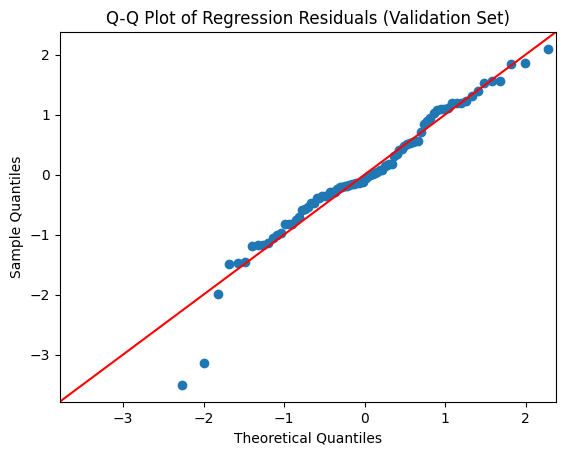

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
val_split["source_fkgl"] = val_split["source"].apply(lambda x: textstat.flesch_kincaid_grade(str(x)))
val_split["target_fkgl"] = val_split["target"].apply(lambda x: textstat.flesch_kincaid_grade(str(x)))
val_split["generated_fkgl"] = val_split["generated"].apply(lambda x: textstat.flesch_kincaid_grade(str(x)))

print("=== FKGL Averages (Validation 20%) ===")
print(val_split[["source_fkgl", "target_fkgl", "generated_fkgl"]].mean())

# --- ANOVA: Are FKGL levels significantly different? ---
print("\n=== ANOVA: Readability Differences Among Groups ===")
anova_f, anova_p = stats.f_oneway(
    val_split["source_fkgl"],
    val_split["target_fkgl"],
    val_split["generated_fkgl"]
)
print(f"F-statistic = {anova_f:.3f}, p-value = {anova_p:.4e}")

if anova_p < 0.05:
    print("Significant difference in readability between groups (p < 0.05).")
else:
    print("No significant difference in readability across groups (p ≥ 0.05).")

# --- Regression 1: target ~ source ---
model1 = smf.ols("target_fkgl ~ source_fkgl", data=val_split).fit()
print("\n=== Regression: Target FKGL ~ Source FKGL ===")
print(model1.summary())
print(f"R² = {model1.rsquared:.3f}, p = {model1.pvalues['source_fkgl']:.3e}")

# --- Regression 2: target ~ generated ---
model2 = smf.ols("target_fkgl ~ generated_fkgl", data=val_split).fit()
print("\n=== Regression: Target FKGL ~ Generated FKGL ===")
print(model2.summary())
print(f"R² = {model2.rsquared:.3f}, p = {model2.pvalues['generated_fkgl']:.3e}")

# --- Regression 3: target ~ source + generated + direction ---
model3 = smf.ols("target_fkgl ~ source_fkgl + generated_fkgl + C(direction)", data=val_split).fit()
print("\n=== Regression: Target FKGL ~ Source + Generated + Direction ===")
print(model3.summary())

# --- Diagnostic Q-Q Plot ---
sm.qqplot(model3.resid, line='45', fit=True)
plt.title("Q-Q Plot of Regression Residuals (Validation Set)")
plt.show()

=== Average FKGL by Direction ===
    direction  source_fkgl  target_fkgl  generated_fkgl
0    adv→elem    11.146348     8.147233        8.386233
1   adv→inter    11.172783     9.909548        8.070191
2  inter→elem    10.336572     8.526289        7.915232

=== FKGL Difference (Target - Generated) by Direction ===
    direction  target_fkgl  generated_fkgl  Δ (Target - Generated)
0    adv→elem     8.147233        8.386233               -0.239000
1   adv→inter     9.909548        8.070191                1.839357
2  inter→elem     8.526289        7.915232                0.611058


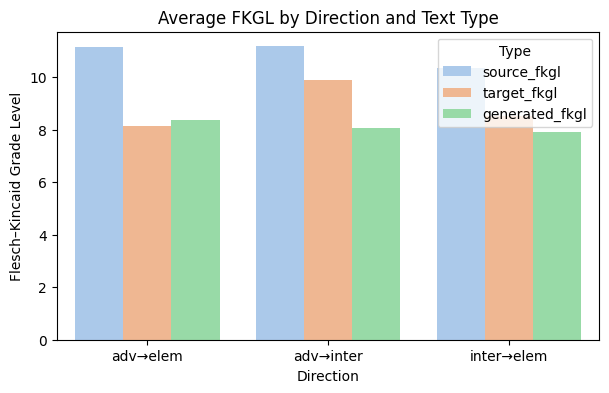


ANOVA between to_elem vs to_inter generated FKGL: F = 0.383, p = 5.3705e-01
No significant difference detected (model treats levels similarly).


In [ ]:
group_summary = val_split.groupby("direction")[["source_fkgl", "target_fkgl", "generated_fkgl"]].mean().reset_index()
print("=== Average FKGL by Direction ===")
print(group_summary)

# --- Pairwise differences (Target & Generated) ---
pivot = group_summary[["direction", "target_fkgl", "generated_fkgl"]]
pivot["Δ (Target - Generated)"] = pivot["target_fkgl"] - pivot["generated_fkgl"]
print("\n=== FKGL Difference (Target - Generated) by Direction ===")
print(pivot)

# --- Visualization ---
plt.figure(figsize=(7,4))
sns.barplot(data=group_summary.melt(id_vars="direction", var_name="Type", value_name="FKGL"),
            x="direction", y="FKGL", hue="Type", palette="pastel")
plt.title("Average FKGL by Direction and Text Type")
plt.ylabel("Flesch–Kincaid Grade Level")
plt.xlabel("Direction")
plt.show()

# --- ANOVA test: generated readability difference across directions ---
anova_F, anova_p = stats.f_oneway(
    val_split[val_split["direction"].str.contains("elem")]["generated_fkgl"],
    val_split[val_split["direction"].str.contains("inter")]["generated_fkgl"]
)
print(f"\nANOVA between to_elem vs to_inter generated FKGL: F = {anova_F:.3f}, p = {anova_p:.4e}")
if anova_p < 0.05:
    print("Significant readability difference between to_elem and to_inter directions.")
else:
    print("No significant difference detected (model treats levels similarly).")